# Finding the edge of one pinture using Quantum Paralelism

This notebook is based on the paper:

[Yao, X.-W.](https://arxiv.org/abs/1801.01465), et al. (2017). Quantum Image Processing and Its Application to Edge Detection: Theory and Experiment. Physical Review X, 7(3), 031041. http://doi.org/10.1103/PhysRevX.7.031041

The main objective of this algorithm is to find the edge of one image. This means, given the image:

<img src="./Images/C.png">

the objective is to find its edges to get this other image:

<img src="./Images/C_EDGES.png">

The algorithm has the next steps:

1. Load the image as a matrix os (n,m) elements $c_{ij}$
$$D=\begin{bmatrix} 
d_{11} & d_{12} & \cdots&d_{1j}&\cdots&d_{1m}  \\
d_{21} & d_{22} & \cdots&d_{2j}&\cdots &d_{2m}  \\
\vdots&&\ddots&\vdots&\ddots&\vdots\\
d_{i1} & d_{i2} & \cdots&d_{ij}&\cdots &d_{im}  \\
\vdots&&\ddots&\vdots&\ddots&\vdots\\
d_{n1} & d_{n2} & \cdots&d_{nj}&\cdots &d_{nm}  \\
\end{bmatrix}$$
2. Convert the array in a vector of N=n\*m elements
$$C=\begin{bmatrix} 
d_{11}   \\
d_{21}   \\
\vdots\\
d_{ij}   \\
d_{(i+1) j}   \\
\vdots\\
d_{nm} \\
\end{bmatrix}=
\begin{bmatrix} 
c_{0}   \\
c_{1}   \\
\vdots\\
c_{N-2}   \\
c_{N-1}   \\
\end{bmatrix}
$$
3. Map this vector to one qureg of $q=log_2(N)$ qubits as
$${\lvert}\phi(C){\rangle}=\frac{1}{{\left\lVert C \right\rVert}^2}\sum_{k=0}^{N-1}c_{k}{\lvert}k{\rangle}$$
4. Apply a Hadamard gate to the last qubit
$$(I^{\otimes q-1}\otimes H)\lvert\phi(C)\rangle=\begin{bmatrix} 
c_{0}+c_{1}   \\
c_{0}-c_{1}   \\
\vdots\\
c_{N-2}+c_{N-1}\\
c_{N-2}-c_{N-1}\\
\end{bmatrix}$$
So, even elements will be close to 0 is two pixels have close values -in the case of black and white images, they must be 0-. Measuring the last qubit, if the result is one, the final states $\lvert k \rangle$, encode the pixels of the boundaries.



Start importing the packages to use. To load and convert the image, PIL package is needed

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
from projectq.cengines import MainEngine
from projectq.ops import H,_state_prep
from PIL import Image
import numpy as np
from numpy import linalg as LA

Load the image. Because it is too large, rescale it.

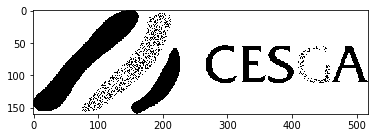

In [5]:
A=Image.open("Images/cesga_unha_tinta.jpg").convert("1")
maxsize=(A.size[0]//4,A.size[1]//4)
A.thumbnail(maxsize, Image.ANTIALIAS)
im_arr = (np.array(A)==False).astype(np.int8)
plt.imshow(im_arr, cmap='Greys' )

Because even after rescaling the image is to large to simulate, crop it around **C**

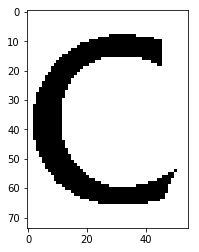

In [6]:
im_crop=im_arr[46:120,265:320]
plt.imshow(im_crop, cmap='Greys' )


Calculate the number of qubits needed to store all the image. Remember that n qubits can store $N=2^ n$ complex numbers. As consequence, to store m\*n pixels, a qureg of $q=\log_2(n*m)$ qubits is used

In [7]:
number_of_qubits=int(np.ceil(np.log2(im_crop.shape[0]*im_crop.shape[1])))
print(number_of_qubits)

12


Create a vector with the number of elements that number_of_qubits can store

In [8]:
Vector=np.zeros((2**number_of_qubits))
print("Print %d qubits can store %d elements."%(number_of_qubits,Vector.shape[0]))

Print 12 qubits can store 4096 elements.


Now, map the image to the first elements of this vector

In [9]:
shape=im_crop.shape[0]*im_crop.shape[1]
Vector[0:shape]=im_crop.reshape((shape))

Because the norm of the amplitudes of one quantum state must be one, we must convert this vector to a normalized one, dividing each element by the norm of the vector. 

In [10]:
from numpy import linalg as LA
norma=LA.norm(Vector)
Vnorma=Vector/norma

Allocate one qureg with the number of needed qubits.

In [11]:
eng=MainEngine()
q=eng.allocate_qureg(number_of_qubits)

Now, use the operation [StatePreparation](https://projectq.readthedocs.io/en/latest/projectq.ops.html#projectq.ops.StatePreparation) to generate the quantum circuit to map the Vnorma vector to one quantum state. This operation will generate the set of gates to transform the initial state $\lvert 0 \rangle^{\otimes q}$ to the desired final state $\lvert \phi \rangle$ using the algorithm proposed by [Mikko Mottonen et al.](https://arxiv.org/abs/quant-ph/0407010). There are other methods implemented on the literature that deserve to be explored because this is a critical point of many modern algorithms.

In [12]:
CreateState=_state_prep.StatePreparation(Vnorma)

OK. Apply this circuit to the allocated qureg

In [13]:
CreateState | q

Do not to forget that any operation must be executed before getting the results. Because this circuit is simulated and not executed on a quantum processor, it will consume some minutes to finish. Be patient!

In [14]:
eng.flush()


In the simulator, it is possible to obtain the current state and probabilities without measuring it. 

In [15]:
Vout=np.zeros(shape)
for i in range(shape):
    bits=np.binary_repr(i,width=len(q))
    Vout[i]=abs(eng.backend.get_probability(bits[-1::-1],q))
    

Remember that the amplitude of one state is the square root of the probability. Plot the results and compare the initial normalized vector with the amplitudes of the final state.

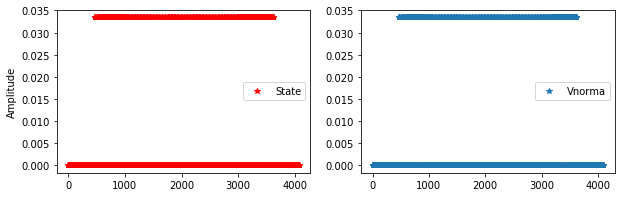

In [16]:
fig,ax=plt.subplots(1,2,figsize=(10,3))
ax[0].plot(Vout**0.5,"r*",label="State")
ax[0].legend()
ax[0].set_ylabel("Amplitude")
ax[1].plot(Vnorma,"*",label="Vnorma")
ax[1].legend()


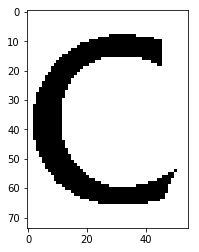

In [17]:
IMOutput=np.round((Vout**0.5)*norma)
plt.imshow(IMOutput.reshape((im_crop.shape[0],im_crop.shape[1])), cmap='Greys')

Now, apply the Hadamard gate to the last qubit. 

In [18]:
H|q[0]
eng.flush()

In the real case, a large number of measurements of the final state have to be done to obtain the probabilities of the final state. In fact, the algorithm needs to measure the last qubit and, when the results is one, the result state is the solution.However, in the simulator, you can recover them directly, and take only those that are due to last state equal to 1, this means, the natural odd numbers.

In [19]:
eng.backend.collapse_wavefunction([q[0]], [1])
Vout=np.zeros(shape)
IMOutputOdd=np.zeros(shape)
for i in range(shape):
    bits=np.binary_repr(i,width=len(q))
    Vout[i]=abs(eng.backend.get_probability(bits[-1::-1],q))
    if (Vout[i]>0.0001):
        IMOutputOdd[i]=1.0


Text(0.5, 1.0, 'New transformed image')

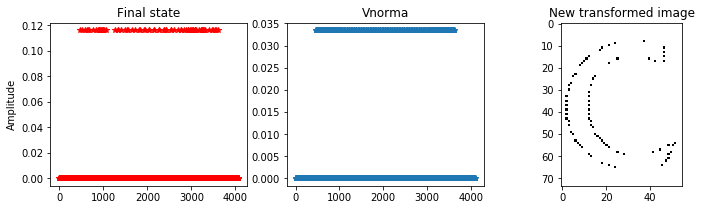

In [20]:
fig,ax=plt.subplots(1,3,figsize=(12,3))
ax[0].plot(Vout**0.5,"r*",label="Final state")
ax[0].set_title("Final state")
ax[0].set_ylabel("Amplitude")
ax[1].plot(Vnorma,"*",label="Vnorma")
ax[1].set_title("Vnorma")
ax[2].imshow(IMOutputOdd.reshape((im_crop.shape[0],im_crop.shape[1])), cmap='Greys')
ax[2].set_title("New transformed image")

OK. Look the final result after applying a single gate. Remember that only even elements are needed

Only half of the borders have been calculated. To calculate the even borders, the algorithm must be executed permuting the input vector by one position.

In [21]:
eng2=MainEngine()
q2=eng2.allocate_qureg(number_of_qubits)
CreateState2=_state_prep.StatePreparation(np.take(Vnorma,range(1,len(Vnorma)+1),mode="warp"))
CreateState2 | q2
H |q2[0]
eng2.flush()

Get the final amplitudes of this case from the simulator

In [22]:
eng2.backend.collapse_wavefunction([q[0]], [1])
Vout=np.zeros(shape)
IMOutputEven=np.zeros(shape)
for i in range(shape):
    bits=np.binary_repr(i,width=len(q))
    Vout[i]=abs(eng2.backend.get_probability(bits[-1::-1],q))
    if (Vout[i]>0.0001):
        IMOutputEven[i+1]=1.0

Plot the result of this second execution

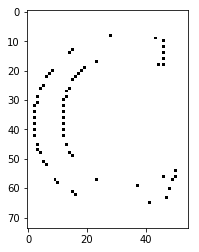

In [23]:
plt.imshow(IMOutputEven.reshape((im_crop.shape[0],im_crop.shape[1])), cmap='Greys')

And combine both outputs to produce the final

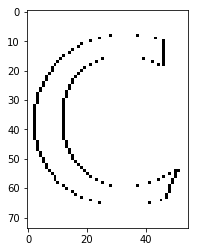

In [24]:
plt.imshow((IMOutputOdd+IMOutputEven).reshape((im_crop.shape[0],im_crop.shape[1])), cmap='Greys')